In [8]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import cv2

def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")


def load_dicom_stack(dicom_folder: str, plane: str, reverse_sort: bool = False) -> dict:
        dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
        dicoms = [pydicom.dcmread(f) for f in dicom_files]
        plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
        positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
        # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
        # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
        idx = np.argsort(-positions if reverse_sort else positions)
        ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
        iop = np.asarray([d.ImageOrientationPatient for d in dicoms]).astype("float")[idx]
        first_dicom = pydicom.dcmread(dicom_files[0])
        target_shape = first_dicom.pixel_array.shape
        array = np.stack([cv2.resize(d.pixel_array.astype("float32"), target_shape) for d in dicoms])
        array = array[idx]
        sorted_files = [dicom_files[i] for i in idx]
        return {"array": convert_to_8bit(array), "positions": ipp, "orientations": iop, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float"), "sorted_files": sorted_files}


train_desc_path = r"F:\Projects\Kaggle\RSNA-2024-Lumbar-Spine-Degenerative-Classification\train_series_descriptions.csv"

df = pd.read_csv(train_desc_path)
study = df.loc[df.study_id == df.study_id.iloc[0]]
study

image_dir = r"F:\Projects\Kaggle\RSNA-2024-Lumbar-Spine-Degenerative-Classification\train_images" + "\\" 



  0%|          | 0/6294 [00:00<?, ?it/s]

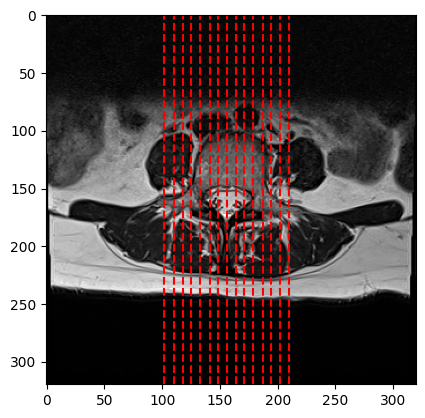

  0%|          | 1/6294 [00:00<1:22:10,  1.28it/s]

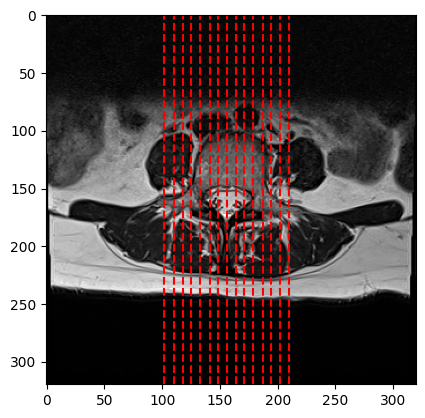

  0%|          | 2/6294 [00:01<1:23:18,  1.26it/s]

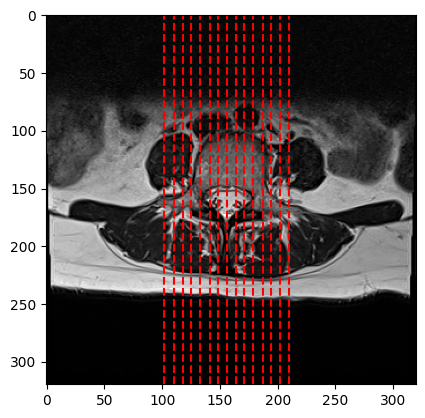

  0%|          | 3/6294 [00:02<1:31:13,  1.15it/s]


KeyboardInterrupt: 

In [9]:
from tqdm import tqdm
def plot_axial(study):
    for row in study.itertuples():
        if row.series_description == "Sagittal T2/STIR":
            sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        elif row.series_description == "Sagittal T1":
            sag_t1 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        elif row.series_description == "Axial T2":
            ax_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="axial", reverse_sort=True)
    top_left_hand_corner_ax_t2 = ax_t2["positions"][len(ax_t2["array"]) // 2]
    top_left_hand_corner_ax_t2

    ax_x_axis_to_pixel_space = [top_left_hand_corner_ax_t2[0]]
    while len(ax_x_axis_to_pixel_space) < ax_t2["array"].shape[2]: 
        ax_x_axis_to_pixel_space.append(ax_x_axis_to_pixel_space[-1] + ax_t2["pixel_spacing"][0])
        # **NOTE: Coordinates INCREASE (i.e. become more positive) from RIGHT to LEFT

    ax_x_coord_to_sag_slice = {}
    for sag_t2_slice, sag_t2_pos in zip(sag_t2["array"], sag_t2["positions"]):
        diffs = np.abs(np.asarray(ax_x_axis_to_pixel_space) - sag_t2_pos[0])
        ax_x_coord = np.argmin(diffs)
        ax_x_coord_to_sag_slice[ax_x_coord] = sag_t2_slice
        
    mid_ax_slice = ax_t2["array"][len(ax_t2["array"]) // 2]
    plt.imshow(mid_ax_slice, cmap="gray")
    for k in [*ax_x_coord_to_sag_slice]: 
        plt.axvline(x=k, color="red", linestyle="--")

    plt.show()

for i in tqdm(range(len(df))):
    study = df.loc[df.study_id == df.study_id.iloc[i]]
    plot_axial(study)